In [1]:
import numpy as np
import pandas as pd
import pidly,os,emcee,corner,re
import matplotlib.pyplot as plt
from astroquery.ipac.ned import Ned
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.constants import h,k,c
from scipy.interpolate import RegularGridInterpolator
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from my_script import mol_data,run_myradex_of,limit_f
from matplotlib.ticker import MaxNLocator
from multiprocessing import Pool
from cycler import cycler

In [2]:
mols={'CO':'co.dat',
     '13CO':'13co.dat',
     'HCN':'hcn.dat',
     'HCOp':'hco+@xpol.dat',
     'CS':'cs@lique.dat',
#     'CI':'catom.dat',
     'C18O':'c18o.dat'}
#     'CN':'cn.dat'}
ab_guess={'CO':1e-4,
         '13CO':2e-6,
         'HCN':7e-8,
         'HCOp':1e-8,
         'CS':1e-7,
         'C18O':1e-6,
         'CN':1e-6}
Tbg=2.73
gas_dust_ratio=100
moldats={}
for key in mols.keys():
    moldats[key]=mol_data('/home/zj/Documents/radex_mol/',mols[key])
    
ini_pop={}
for key in mols.keys():
    ini_pop[key]=fits.open('%s_radex.fits'%key)[0]
def linear_nearest(value,start,delta,N):
    i=int(np.round((value-start)/delta))
    return i-(i>=N)*(i-N+1)-(i<0)*i
from wrapper_my_radex import myradex_wrapper as wrapper
def dvdrvir(nH2):
    return 0.65*1.5**0.5*(nH2/1e3)**0.5
def run_myradex_fix(Tkin=0,nH2=0,abundance_Kvir=1e-4,Tbg=2.73,molecule={},pophdu=[]):
    lg_Tkin,lg_nH2,lg_ab_K=np.log10(Tkin),np.log10(nH2),np.log10(abundance_Kvir)
    inside_1=pophdu.header['CRVAL4']<lg_Tkin<pophdu.header['CRVAL4']+pophdu.header['CDELT4']*pophdu.header['NAXIS4']
    inside_2=pophdu.header['CRVAL3']<lg_nH2<pophdu.header['CRVAL3']+pophdu.header['CDELT3']*pophdu.header['NAXIS3']
    inside_3=pophdu.header['CRVAL2']<lg_ab_K<pophdu.header['CRVAL2']+pophdu.header['CDELT2']*pophdu.header['NAXIS2']
    if inside_1*inside_2*inside_3:
        iTkin=linear_nearest(lg_Tkin,pophdu.header['CRVAL4'],pophdu.header['CDELT4'],pophdu.header['NAXIS4'])
        inH2=linear_nearest(lg_nH2,pophdu.header['CRVAL3'],pophdu.header['CDELT3'],pophdu.header['NAXIS3'])
        iabK=linear_nearest(lg_ab_K,pophdu.header['CRVAL2'],pophdu.header['CDELT2'],pophdu.header['NAXIS2'])
        ini_occ=pophdu.data[iTkin,inH2,iabK]
    else:
        ini_occ=[]
    if len(ini_occ)==0:
        ini_occ=molecule.level_weight*np.exp(-molecule.level_energy/Tkin)
        ini_occ=ini_occ/sum(ini_occ)
    lamb = 3.08e18*abundance_Kvir/dvdrvir(nH2)
    NXcol=nH2*lamb
    params = {'tkin': Tkin,
              'ncol_x_cgs': NXcol,
              'h2_density_cgs': nH2,
              'hi_density_cgs': 0,
              'hp_density_cgs': 0,
              'e_density_cgs': 0,
              'tbg':Tbg,
              'mol_name':molecule.mol_name[0],
              'data_shape':molecule.data_shape,
              'n_transition':molecule.data_shape[1],
              'partner_names':molecule.part_name_str,
              'colli_shape':molecule.colli_shape,
              'level_data':molecule.level_data,
              'rad_data':molecule.rad_data,
              'colli_t':molecule.colli_T,
              'colli_data':molecule.colli_Cul,
              'ini_occ':ini_occ}      #initial occupation
    Tb,f_occupation=wrapper.run_one_params(**params)
    return Tb,f_occupation

In [3]:
idl=pidly.IDL('idl')
def loadfits(name):
    hdu=fits.open(name)
    idx=0
    while True:
        if hdu[idx].data is None:
            idx+=1
        else:
            break
    return hdu[idx]
def beam_flux(hdu,ra,dec,beam):
    w=WCS(hdu.header)
    c=SkyCoord(ra,dec,frame="icrs",unit=(u.hourangle, u.deg))
    data=hdu.data
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (int(data.shape[0]/10),int(data.shape[1]/10)),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,exclude_percentile=50)
    data=data-np.mean(bkg.background)
    pixel=w.world_to_pixel(c)
    x,y=np.arange(data.shape[0]),np.arange(data.shape[1])
    f=RegularGridInterpolator((x,y),data,method='linear')
    if hdu.header['BUNIT']=='MJy/sr':
        ufactor=beam**2/37550.9
    elif hdu.header['BUNIT']=='Jy/pixel':
        ufactor=1.133*beam**2/abs(hdu.header['CDELT1']*hdu.header['CDELT2']*3600**2)
    elif hdu.header['BUNIT']=='mJy/arcsec**2':
        ufactor=1.133*beam**2/1000
    elif hdu.header['BUNIT']=='Jy/beam':
        ufactor=1
    try:
        flux=float(f(pixel[::-1]))*ufactor
    except ValueError:
        print("Coordinates of %s %s band doesn't match!"%(sourcename,tels[i]))
        return np.array([np.nan,np.nan])
    if np.isnan(flux):
        flpix=np.floor(pixel[::-1])
        flux=np.nanmean([data[tuple(flpix.astype(int)+np.array([0,0]))],data[tuple(flpix.astype(int)+np.array([1,0]))],\
                         data[tuple(flpix.astype(int)+np.array([0,1]))],data[tuple(flpix.astype(int)+np.array([1,1]))]])
    error=np.std(bkg.background)*ufactor
    return np.array([flux,error])
# ratio of convoloved flux from smaller beam image (PACS160) 
def beam_factor(galaxy,orgbeam,targbeam):
    name=galaxy.name
    ra,dec=galaxy.ra,galaxy.dec
    for beam in [orgbeam,targbeam]:
        if os.path.exists('dust_IR/convolved_images/%s_160_to_%3.1f.fits'%(name,beam)):
            continue
        kerfile='Kernel_HiRes_PACS_160_to_Gauss_%3.1f'%beam
        if not os.path.exists('/DATA/zj/gasmass_estimation_230220/convolve/Kernels/'+kerfile+'.fits'):
            parfile='/DATA/zj/CI_gasmass/dust_SED/photometry/make_kernel/Parameters/Parameters_file_PACS160_to_tmp.dat'
            f=open(parfile,'r',encoding='utf-8')
            flist=f.readlines()
            flist[17]="Gauss %3.1f\n"%beam
            flist[18]='Gauss_%3.1f           Filename of the PSF\n'%beam
            flist[23]='%3.1f                 Gaussian  FWHM\n'%beam
            f=open(parfile,'w',encoding='utf-8')
            f.writelines(flist)
            f.close()
            idl.filename='Parameters_file_PACS160_to_tmp'
            idl('.compile /DATA/zj/CI_gasmass/dust_SED/photometry/make_kernel/IDL_Routines/make_kernel_v21.pro')
            idl('make_kernel_v21,filename')
            os.system('cp /DATA/zj/CI_gasmass/dust_SED/photometry/make_kernel/Kernels/Ker_PACS160_to_tmp/Kernel_HiRes_PACS_160_to_Gauss_%3.1f.fits.gz /DATA/zj/gasmass_estimation_230220/convolve/Kernels/'%beam)
            os.system('gzip -d /DATA/zj/gasmass_estimation_230220/convolve/Kernels/*.gz')
        idl.kername=kerfile
        idl.imagename='%s_160'%name
        if not os.path.exists('dust_IR/%s_160.fits'%name):
            print('There is no IR data for beam correcting: dust_IR/%s_160.fits'%name)
        os.system('cp dust_IR/%s_160.fits /DATA/zj/gasmass_estimation_230220/convolve/Images/'%(name))
        idl('.compile /DATA/zj/gasmass_estimation_230220/convolve/IDL_Routines/convolve_image.pro')
        idl('convolve_image,kername,imagename')
        os.system('mv /DATA/zj/gasmass_estimation_230220/convolve/Images/%s_160_convolved.fits dust_IR/convolved_images/%s_160_to_%3.1f.fits'%(name,name,beam))
        os.system('rm /DATA/zj/gasmass_estimation_230220/convolve/Images/%s_160_kernel.fits'%name)
    
    hdu=loadfits('dust_IR/convolved_images/%s_160_to_%3.1f.fits'%(name,orgbeam))
    orgflux=beam_flux(hdu,ra,dec,orgbeam)[0]
    hdu=loadfits('dust_IR/convolved_images/%s_160_to_%3.1f.fits'%(name,targbeam))
    targflux=beam_flux(hdu,ra,dec,targbeam)[0]
    factor=targflux/orgflux
    return factor
def kappa_Draine(wl,b):
    return 0.9764*(wl/500)**(-b)                         # https://www.astro.princeton.edu/~draine/dust/dustmix.html 
def Bv(wl,T):
    v=c/wl*1e6
    term=np.exp(h*v/k/T)-1
    Iv=2*h*v**3/c**2/term*1e3                            # erg s^-1 cm^-2 Hz^-1 
    return Iv
def MBB_Ddust(wl,Td,Md,b,distance):
    M=Md*1.989E33                                        # Msun -> g
    D=distance*3.08567758e24                             # Mpc -> cm
    Sv=kappa_Draine(wl,b)*M*Bv(wl,Td)/D**2*1e23                 # erg -> Jy
    return Sv

In [4]:

class gas_components:
    def __init__(self,ncomp=1,mols=['CO']):
        self.mols=mols
        self.ncomp=ncomp
    def load_params(self,params):
        self.params=params
        self.comp_params={}
        for i in range(self.ncomp):
            self.comp_params['comp'+str(i)]=params[4*i:4*i+4]
        if 'CO' in self.mols:
            self.comp_params['abundances']=np.concatenate([[1e-4],params[4*self.ncomp:]])
        else:
            self.comp_params['abundances']=params[4*self.ncomp:]
    def compute_Tbs(self,params):
        self.load_params(params)
        self.mol_Tbs,self.mol_lums,self.mol_lum_t={},{},{}
        for imol,mol in enumerate(self.mols):
            Tbs=np.zeros([self.ncomp,moldats[mol].n_transitions])
            lums=np.zeros_like(Tbs)
            for i in range(self.ncomp):
                compparam=self.comp_params['comp'+str(i)]
                Tb,focc=run_myradex_fix(Tkin=compparam[0],nH2=compparam[1],abundance_Kvir=self.comp_params['abundances'][imol]/compparam[2],
                                        Tbg=Tbg,molecule=moldats[mol],pophdu=ini_pop[mol])
                #Tb,focc=run_myradex_of(Tkin=compparam[0],nH2=compparam[1],abundance_Kvir=self.comp_params['abundances'][imol]/compparam[2],Tbg=Tbg,
                #                        molecule=moldats[mol])
                Tbs[i]=Tb
                lums[i]=Tb*np.pi/4/np.log(2)*compparam[3]**2
            self.mol_Tbs[mol]=Tbs
            self.mol_lums[mol]=lums
            self.mol_lum_t[mol]=np.sum(lums,axis=0)
    def get_paramname(self):
        paramname=[]
        for i in range(self.ncomp):
            paramname=np.concatenate([paramname,['Tkin_'+str(i+1),'nH2_'+str(i+1),'Kvir_%d/[CO]'%(i+1),'size/pc']])
        if 'CO' in self.mols:
            paramname=np.concatenate([paramname,[r'$\Lambda_{\rm '+s+'}$/[CO]' for s in self.mols[1:]]])
        else:
            paramname=np.concatenate([paramname,[r'$\Lambda_{\rm '+s+'}$/[CO]' for s in self.mols]])
        return paramname
    def compute_mass(self,icomp):
        p_comp=self.comp_params['comp'+str(icomp)]
        Ncol=3.08e18*p_comp[1]/p_comp[2]*1/(0.65*1.5**0.5*(p_comp[1]/1e3)**0.5)
        mass=Ncol*(2*1.66053904e-24)*np.pi/4/np.log(2)*p_comp[3]**2*3.08567758e18**2/1.98855e33
        return mass
class galaxy:
    def __init__(self,galname):
        self.name=galname
        galinfos=pd.read_csv('sample_basic_info.csv',delimiter=',',index_col='source name')
        if galname in galinfos.index:
            galinfo=galinfos.loc[galname]
            self.ra,self.dec=galinfo['ra'],galinfo['dec']
            self.redshift,self.distance=galinfo['redshift'],galinfo['distance/Mpc']
            self.size,self.dv=galinfo['size/arcsec'],galinfo['FWHM/km/s']
            print(galinfo)
        else:
            print(Ned.query_object(galname)) 
            print('%s infomation is not in sample_basic_info.csv'%galname)
            #exit()
    def load_flux(self,obsfile):
        self.orgfluxfile=obsfile
        data=np.loadtxt(obsfile,delimiter=',',dtype=str)
        mol_flux={}
        for molname in mols.keys():
            if molname in data[0]:
                idx=np.where(data[0]==molname)[0][0]
                flux=data[1:,idx:idx+3]
                flux=np.concatenate([np.array([np.arange(len(flux))+1]).T,flux],axis=1)
                flux=flux[~(flux=='').any(axis=1)].astype(float)
                flux=flux[~(np.isnan(flux[:,1:4]).all(axis=1))]
                mol_flux[molname]=flux
        self.mol_flux=mol_flux
        self.mol_flux_info='[Jup,flux(Jykm/s),error,beam/"]'
    def write_flux(self,file_path):
        nJ=0
        for molname in self.mol_flux.keys():
            nJ=max(nJ,int(self.mol_flux[molname][-1,0]))
        fluxtable=np.empty([nJ+1,4*len(self.mol_flux.keys())],dtype='U64')
        idx=0
        for molname in self.mol_flux.keys():
            fluxtable[0,idx:idx+4]=[molname,'error','beam','ref']
            flux=self.mol_flux[molname]
            Jdet=flux[:,0].astype(int)
            for i in range(Jdet[-1]):
                if i+1 in Jdet:
                    iinflux=np.where(Jdet==i+1)[0][0]
                    fluxtable[i+1,idx:idx+3]=flux[iinflux,1:4]
                    fluxtable[i+1,idx+3]='this work'
                else:
                    fluxtable[i+1,idx:idx+3]=np.nan
                    fluxtable[i+1,idx+3]='no'
            idx+=4
        np.savetxt(file_path,fluxtable,fmt='%s',delimiter=',')
    def beam_match(self,targbeam):
        for molname in self.mol_flux.keys():
            for i in range(len(self.mol_flux[molname])):
                molJflux=self.mol_flux[molname][i]
                if (~np.isnan(molJflux[3])) and (molJflux[3]!=targbeam):
                    factor=beam_factor(self,molJflux[3],targbeam)
                    molJflux[1:3]*=factor
                    molJflux[3]=targbeam
        namelist=self.orgfluxfile.split('.')
        namelist[-2]+='_to_%3.1f'%targbeam
        self.write_flux('.'.join(namelist))
    def draw_SLED(self):
        mols=list(self.mol_flux.keys())
        fig,axs=plt.subplots(len(mols),1,figsize=[7,5*len(self.mol_flux)])
        for i,ax in enumerate(axs):
            molflux=self.mol_flux[mols[i]]
            ax.errorbar(molflux[:,0],molflux[:,1],yerr=molflux[:,2],fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_title('%s %s SLED'%(self.name,mols[i]))
            ax.set_xlabel('Jup')
            ax.set_ylabel('Flux (Jy km/s)')
        if 'fit_sampler' in dir(self):
            print('plot')
            samples=self.fit_sampler.get_chain(discard=7000)
            log_prob_samples = self.fit_sampler.get_log_prob(discard=7000)
            max_index=np.where(log_prob_samples==np.max(log_prob_samples))
            max_params=samples[max_index[0][0],max_index[1][0]]
            self.max_param=max_params
            maxmodel=gas_components(self.ncomp,list(self.mol_flux.keys()))
            maxmodel.compute_Tbs(10**max_params)
            maxlum=maxmodel.mol_lums
            for i,ax in enumerate(axs):
                lum=maxlum[mols[i]]
                Jmodel=np.arange(int(max(self.mol_flux[mols[i]][:,0])+2))
                alpha=3.25e7/(moldats[mols[i]].rad_data[Jmodel,3]/1e9/(1+self.redshift))**2*self.distance**2/(1+self.redshift)**3
                flux=lum[:,Jmodel]/alpha*self.dv
                ax.set_prop_cycle(cycler('color', ['blue','green','red','yellow']))
                for j in range(self.ncomp):
                    ax.plot(Jmodel+1,flux[j],label=r'$T_{\rm kin}=%3.1f {\rm K},{\rm log}\,n_{\rm H_2}=%3.1f, K_{\rm vir}=%3.1f,{\rm size}=%3.1f$'\
                            %(10**max_params[0+4*j],max_params[1+4*j],10**max_params[2+4*j],10**max_params[3+4*j]))
                ax.legend()
                ax.plot(Jmodel+1,np.sum(flux,axis=0),'k')
        fig.tight_layout()
        plt.savefig('fit_results/%s_SLED.pdf'%(self.name))
    def line_flux_lum(self):
        self.mol_lum={}
        for mol in self.mol_flux.keys():
            Jlow=self.mol_flux[mol][:,0].astype(int)-1
            alpha=3.25e7/(moldats[mol].rad_data[Jlow,3]/1e9/(1+self.redshift))**2*self.distance**2/(1+self.redshift)**3
            self.mol_lum[mol]=self.mol_flux[mol][:,1:3]*np.array([alpha]).T
        return self.mol_lum
    def read_prior(self,priorfile='prior.txt'):
        with open(priorfile,'r') as f:
            strlist=f.readlines()
            commandlist,guesslist=[],[]
            comp=0
            commandlist.append('def log_prior(params,lummodel):')
            commandlist.append('    ll=0')
            for i in range(self.ncomp):
                commandlist.append('    lg_Tkin_%d,lg_nH2_%d,lg_Kvir_%d,lg_size_%d=params[%d:%d]'%(i+1,i+1,i+1,i+1,i*4,i*4+4))
            for i,line in enumerate(strlist):
                line=line.strip()
                if re.match('Component( *)(\d)',line):
                    comp=int(re.match('Component( *)(\d)',line).group(2))
                    continue
                if comp<=0 or comp>self.ncomp:
                    continue
                t=re.match('(\d+.\d+|\d+)<(.*)<(\d+.\d+|\d+)',line)
                if t:
                    p=re.search('Tkin|nH2|Kvir|size',t.group(2))
                    if p:
                        r1,r2=float(t.group(1)),float(t.group(3))
                        pname='lg_'+p.group()+'_'+str(comp)
                        if not re.search('log',t.group(2)):
                            r1,r2=np.log10(r1),np.log10(r2)
                        commandlist.append('    ll+=limit_f(%s,%f,%f)'%(pname,r1,r2)) 
                        guesslist.append([np.where(np.array(['Tkin','nH2','Kvir','size'])==p.group())[0][0]+comp*4-4,r1,r2])
                        continue
            commandlist.append('    return ll')
            commandlist.append('func_prior["func"]=log_prior')
        self.commandlist,self.guesslist=commandlist,guesslist
        return commandlist,guesslist
    def fit_SLED(self,ncomp=1,overwrite=False,fit_dust=False,priorfile='prior.txt'):
        self.ncomp=ncomp
        self.fit_dust=fit_dust
        if 'commandlist' not in dir(self):
            self.read_prior(priorfile=priorfile)
        global log_likelyhood
        func_prior={}
        exec('\n'.join(self.commandlist))
        log_prior=func_prior['func']
        def log_likelyhood(params):
            if not is_physical(params):
                return -np.inf
            lummodel=gas_components(ncomp,list(self.mol_flux.keys()))
            lummodel.compute_Tbs(10**params)
            mol_lum=lummodel.mol_lum_t
            ll_mol=0
            minfrac=0
            for mol in mol_lum.keys():
                Jlow=self.mol_flux[mol][:,0].astype(int)-1
                lum=mol_lum[mol][Jlow]*self.dv
                frac=lummodel.mol_lums['CO'][:,self.mol_flux['CO'][:,0].astype(int)-1]/lummodel.mol_lum_t['CO'][self.mol_flux['CO'][:,0].astype(int)-1]
                minfrac_t=np.min(np.max(frac,axis=1))
                if minfrac<minfrac_t:
                    minfrac=minfrac_t
                ll_mol+=-0.5*np.nansum(((obslum[mol][:,0]-lum)/obslum[mol][:,1])**2)
            if self.fit_dust:
                dustmass=0
                for icomp in range(self.ncomp):
                    dustmass+=lummodel.compute_mass(icomp)*self.dv/gas_dust_ratio
                dustmodel=MBB_Ddust(self.dust_flux[:,0],10**params[0],dustmass,2,self.distance)
                ll_mol+=-0.5*np.nansum(((self.dust_flux[:,1]-dustmodel)/self.dust_flux[:,2])**2)
            ll_prior=log_prior(params,lummodel)
            ll_frac=limit_f(minfrac,0.1,1)
            return ll_mol+ll_prior+ll_frac
        def is_physical(params):
            ll=(param_range[0]<params).all() and (params<param_range[1]).all()
            return ll
        obslum=self.line_flux_lum()
        lummodel=gas_components(ncomp,list(self.mol_flux.keys()))
        guess1=np.array([1.4,4,0,2])
        ab_g=[]
        for mol in self.mol_flux.keys():
            if mol != 'CO':
                ab_g.append(ab_guess[mol])
        paramguess=np.concatenate([np.tile(guess1,ncomp),np.log10(ab_g)])
        guesslist=self.guesslist
        for i in range(len(guesslist)):
            paramguess[int(guesslist[i][0])]=(guesslist[i][1]+guesslist[i][2])/2
        param_range=np.array([[1,2,-1,-2],[3,8,2,4]])
        param_range=np.concatenate([np.tile(param_range,ncomp),[np.log10(ab_g)-2,np.log10(ab_g)+2]],axis=1)
        lummodel.compute_Tbs(10**paramguess)
        print(lummodel.compute_mass(0))
        log_likelyhood(paramguess)
        nwalkers,ndim=40,len(paramguess)
        paramerr=np.tile([0.05],ndim)
        p0=paramguess+paramerr* np.random.randn(nwalkers,ndim)
        sampfile='fit_results/%s_sample.h5'%self.name
        if os.path.exists(sampfile) and overwrite==False:
            sampler=emcee.backends.HDFBackend(sampfile, read_only=True)
        else:
            backend = emcee.backends.HDFBackend(sampfile)
            backend.reset(nwalkers,p0.shape[1])
            with Pool(14) as pool:
                sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelyhood, args=(),pool=pool,backend=backend)
                state=sampler.run_mcmc(p0,20000,progress=True)
        self.fit_sampler=sampler
    def draw_corner(self,discard=7000):
        samples=self.fit_sampler.get_chain(discard=discard)
        sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
        lummodel=gas_components(self.ncomp,list(self.mol_flux.keys()))
        fig=corner.corner(sample_reshape, labels=lummodel.get_paramname())
        plt.title(self.name+' corner')
        fig.savefig('fit_results/%s_corner.pdf'%self.name)

ra              16:52:58.86
dec             02:24:03.55
redshift            0.02353
distance/Mpc          103.1
size/arcsec             8.6
FWHM/km/s               360
Name: NGC6240, dtype: object
6971075.9034646675


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [1:01:29<00:00,  5.42it/s]


plot


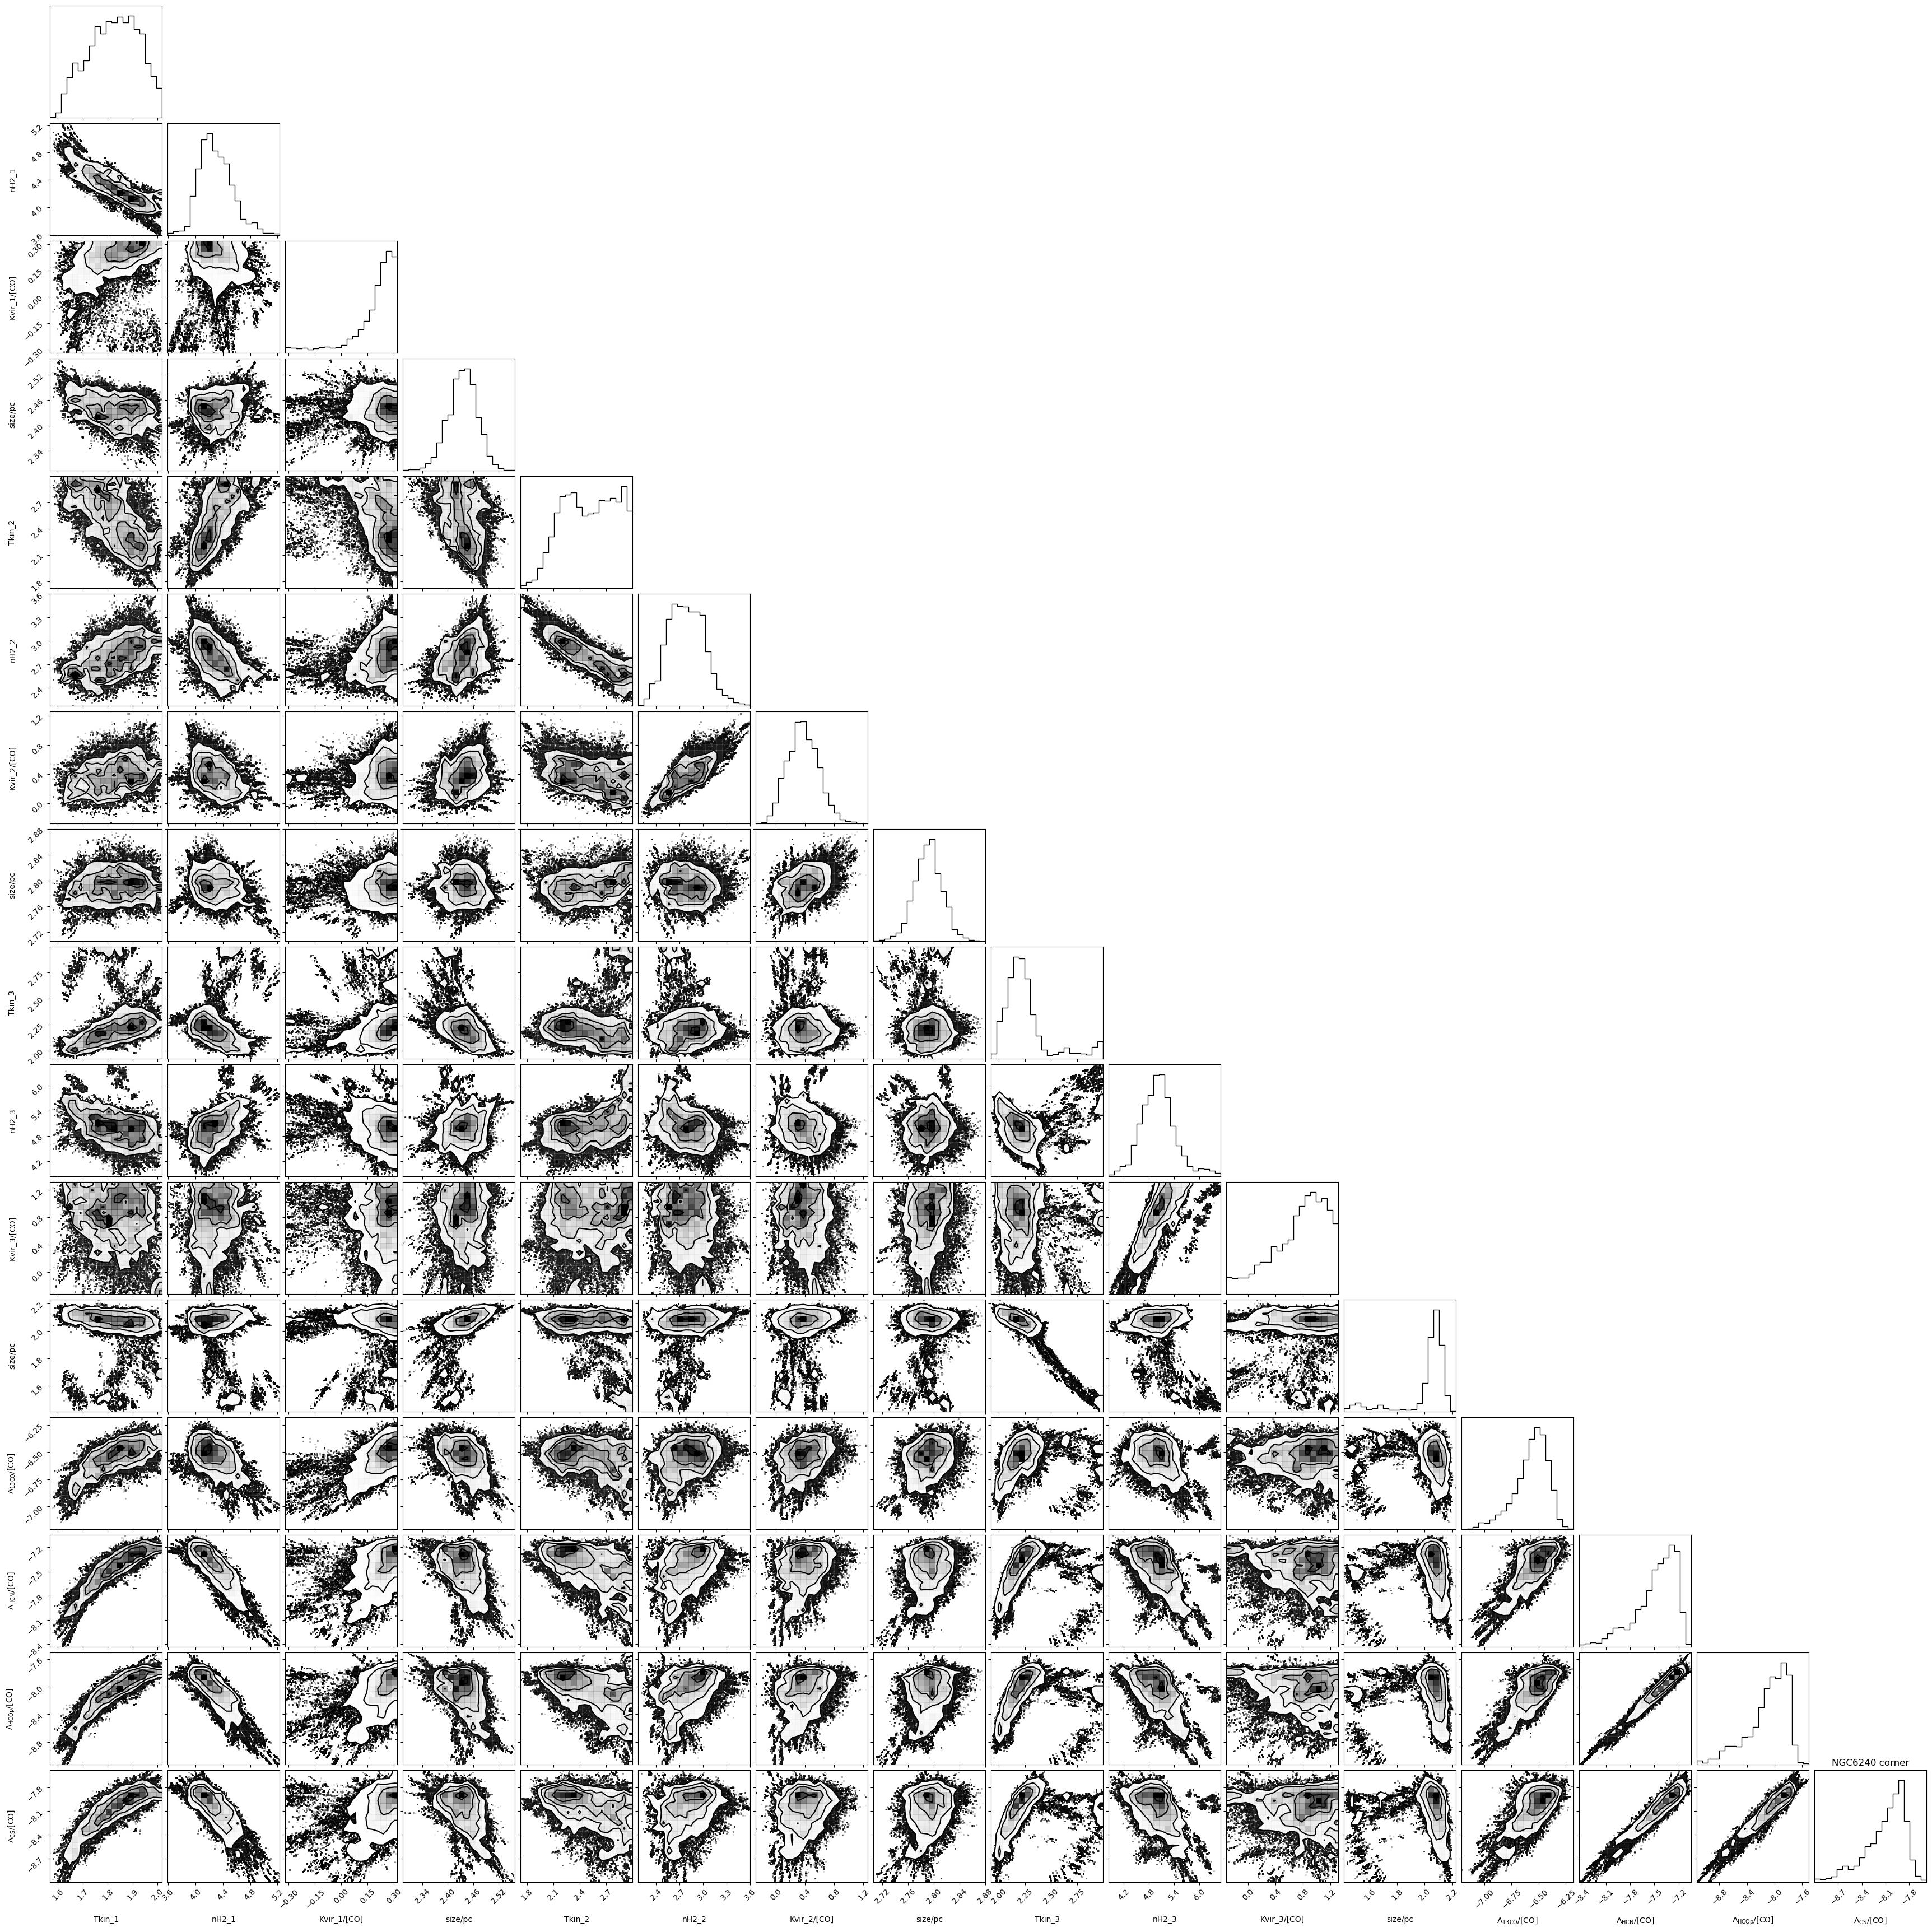

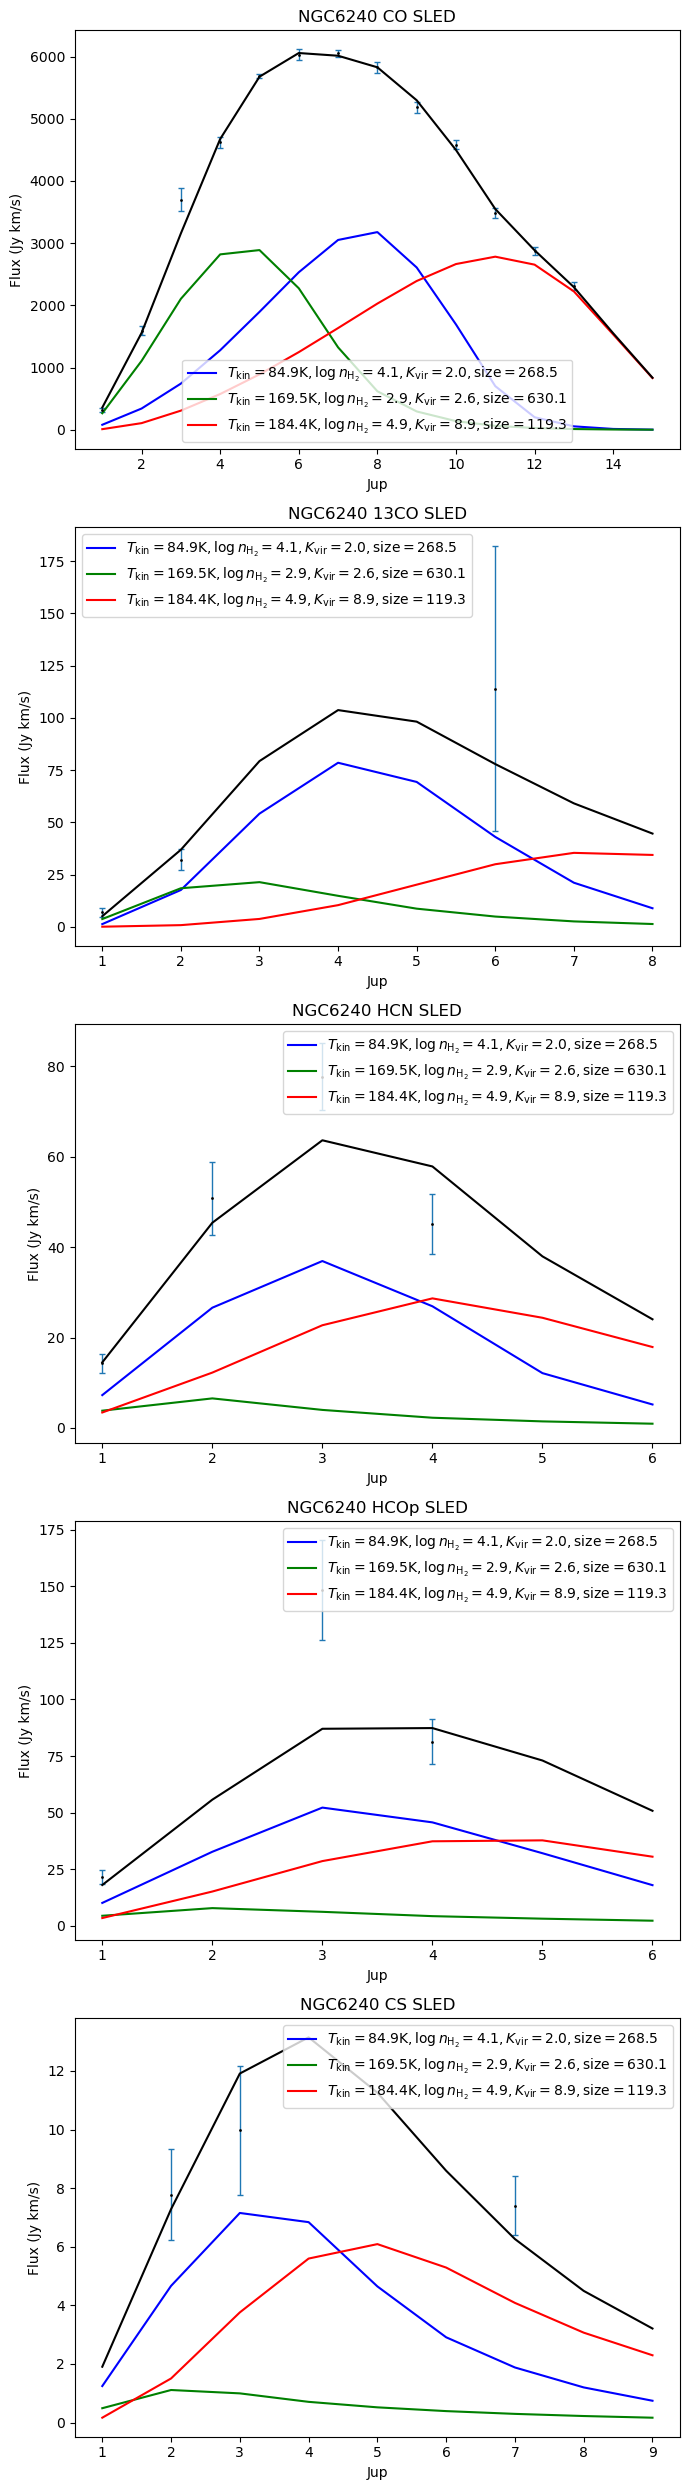

In [5]:
n6240=galaxy('NGC6240')
n6240.load_flux('obs_data/NGC6240_to_40.0.csv')
n6240.mol_flux['CO'][1:5,2]/=2
#n6240.beam_match(40)
n6240.dust_flux=np.array([[70,21.7,2.2],[100,25.6,2.5],[160,17.8,1.8],[250,6,0.6],[350,2.1,0.2],[500,0.5,0.05]])
n6240.ncomp=3
n6240.read_prior(priorfile='prior.txt')
n6240.commandlist.insert(-3,"    ll+=limit_f(lummodel.mol_Tbs['CO'][0,1],20,1000)")
n6240.commandlist.insert(-3,"    ll+=limit_f(lummodel.mol_Tbs['CO'][0,2],20,1000)")
n6240.fit_SLED(ncomp=3,fit_dust=False)
n6240.draw_corner(discard=8000)
n6240.draw_SLED()

In [6]:
def compute_Ncol(nH2,abundance_Kvir):    
    Ncol=3.08e18*nH2*abundance_Kvir*1/(0.65*1.5**0.5*(nH2/1e3)**0.5)  #Papadopoulos et al. (2012)  Tunnard et al. (2015)
    return Ncol
def compute_gasmass(NH2col,area):
    gasmass=NH2col*(2*1.66053904e-24)*area*3.08567758e18**2/1.98855e33 *dv #solar mass
    return gasmass
def param_mass(lg_Tkin,lg_nH2,lg_Kvir,lg_size):
    area=np.pi/4/np.log(2)*(10**lg_size)**2
    Ncol=compute_Ncol(10**lg_nH2,1/10**lg_Kvir)
    lg_gasmass=np.log10(compute_gasmass(Ncol,area))
    return(lg_gasmass)
dv=300
print(param_mass(*n6240.max_param[:4]),param_mass(*n6240.max_param[4:8]),param_mass(*n6240.max_param[8:12]))

9.427500939397584 9.468032677069493 8.476931391100635


ra              13:20:35.34
dec             +34:08:22.2
redshift           0.023056
distance/Mpc          105.0
size/arcsec             2.9
FWHM/km/s               300
Name: Arp193, dtype: object


6971075.9034646675
Too few points to create valid contours
Too few points to create valid contours
plot


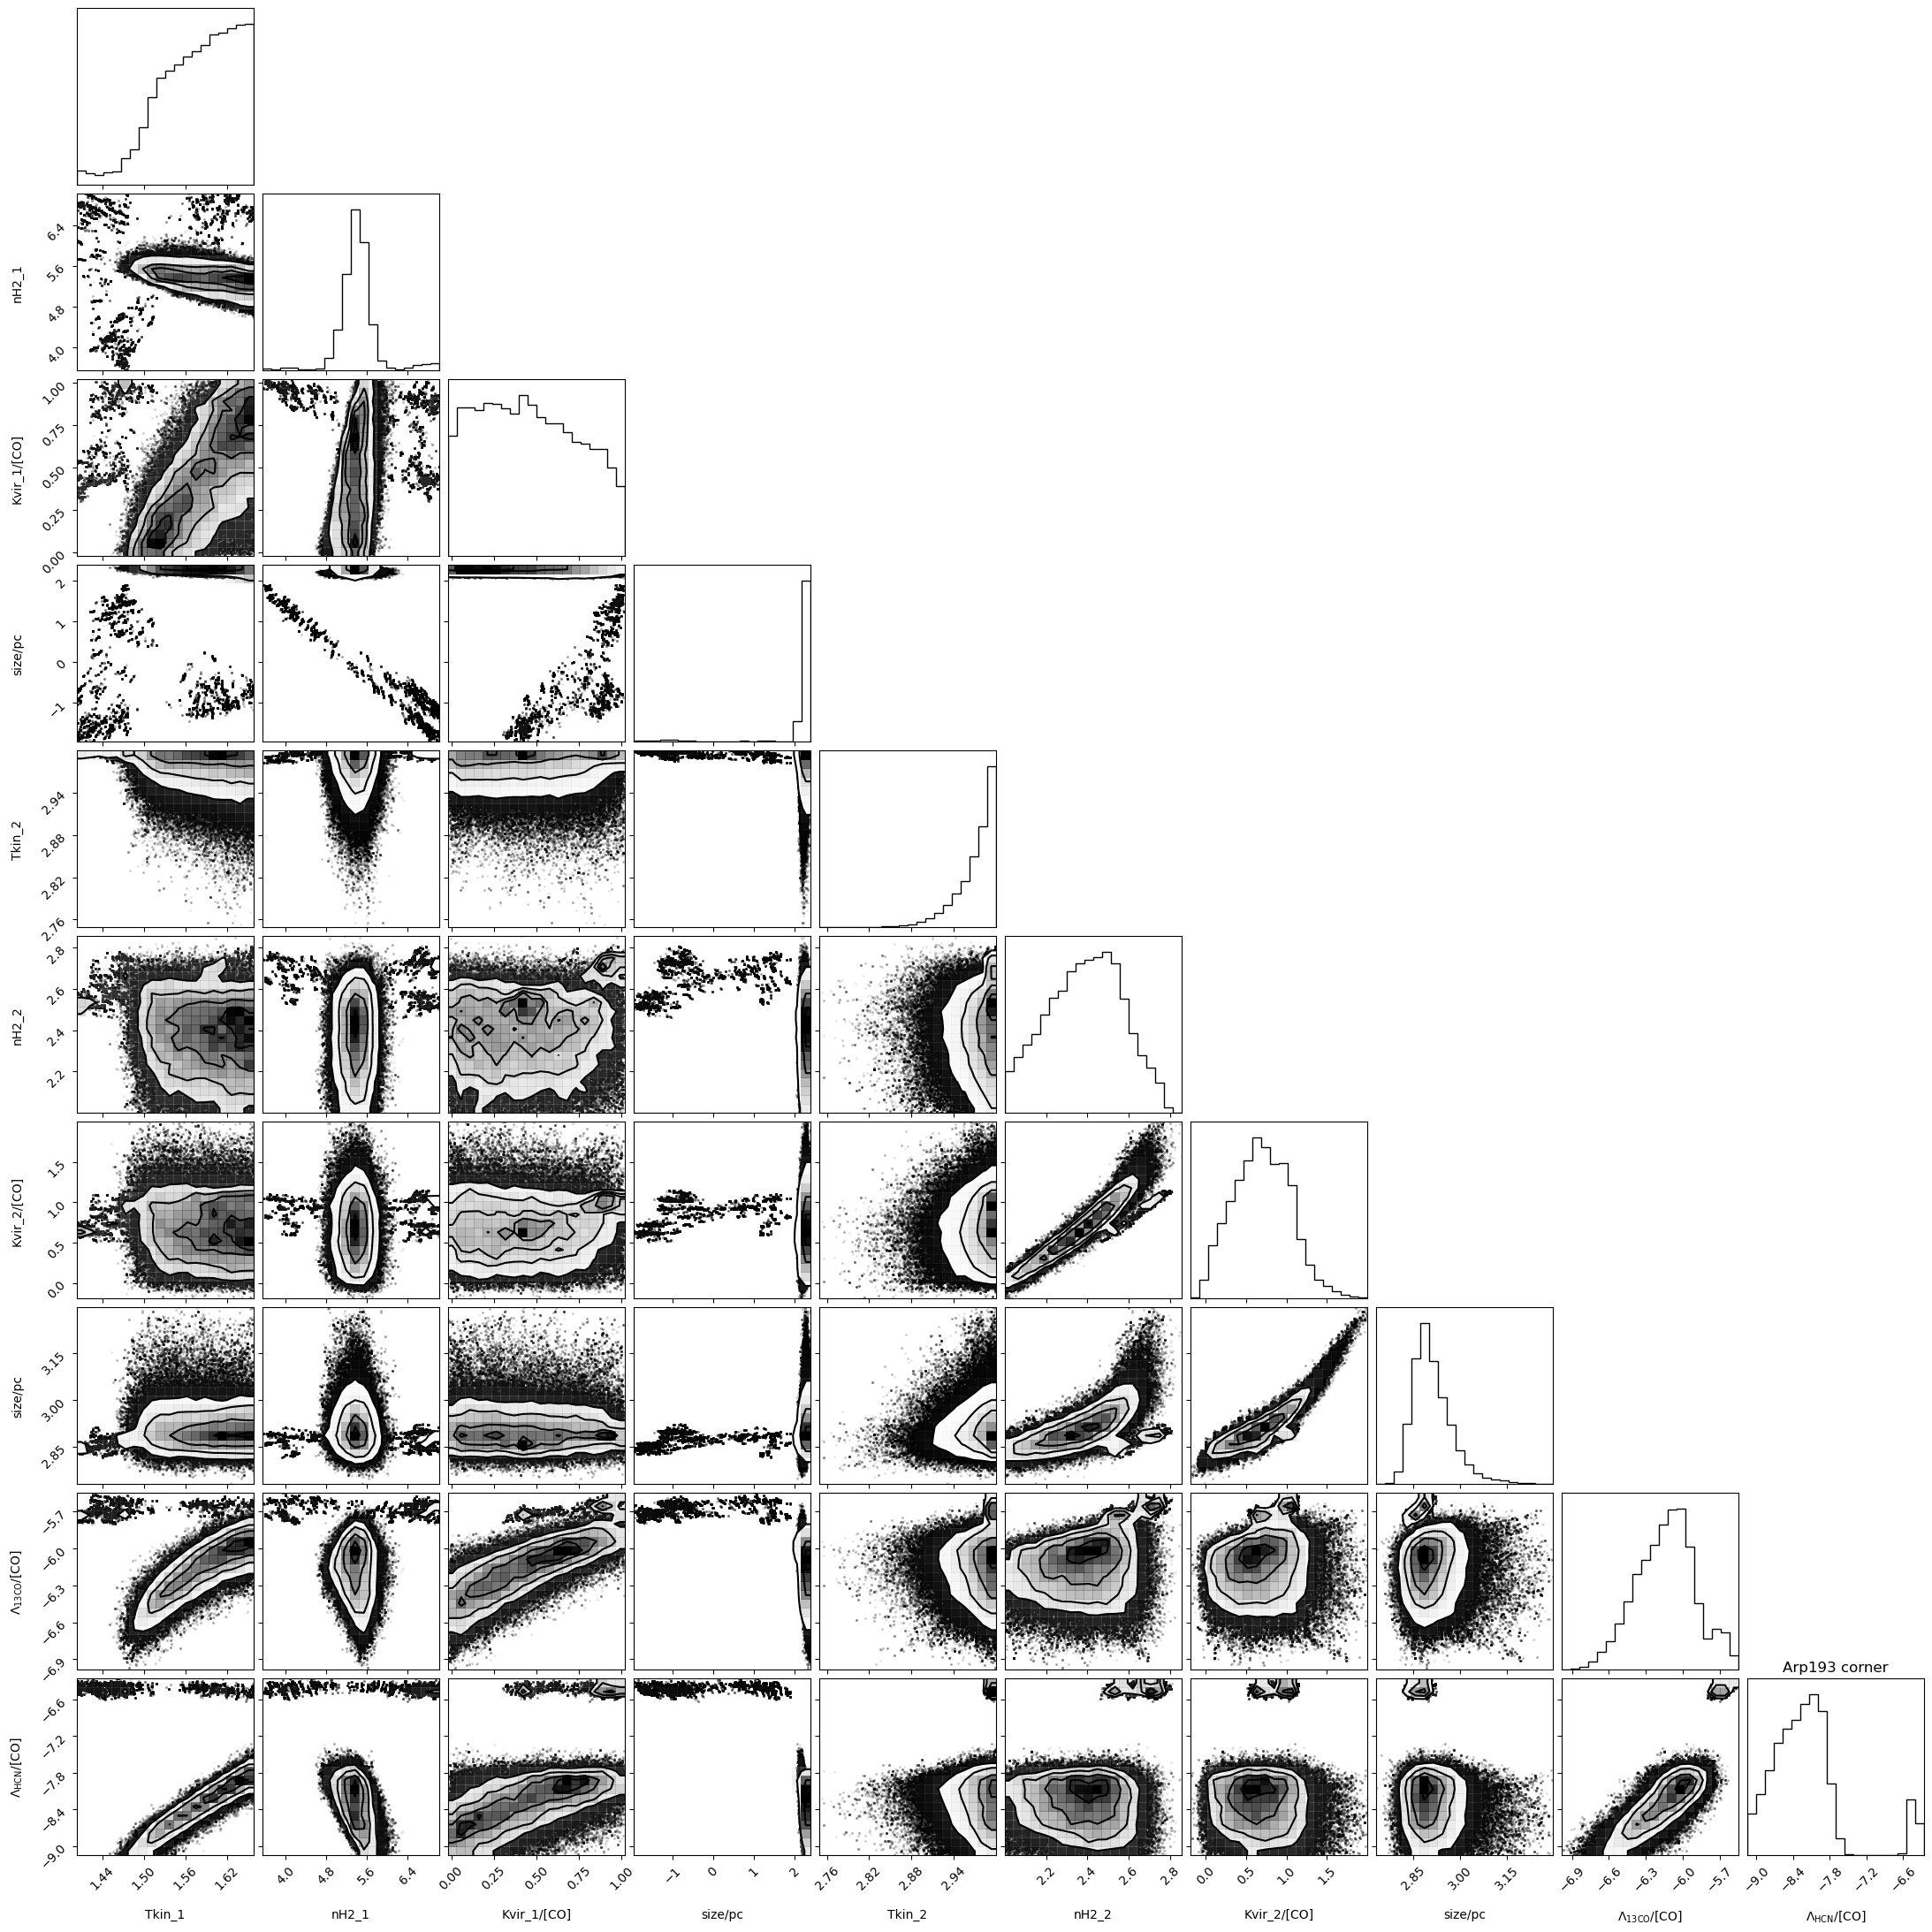

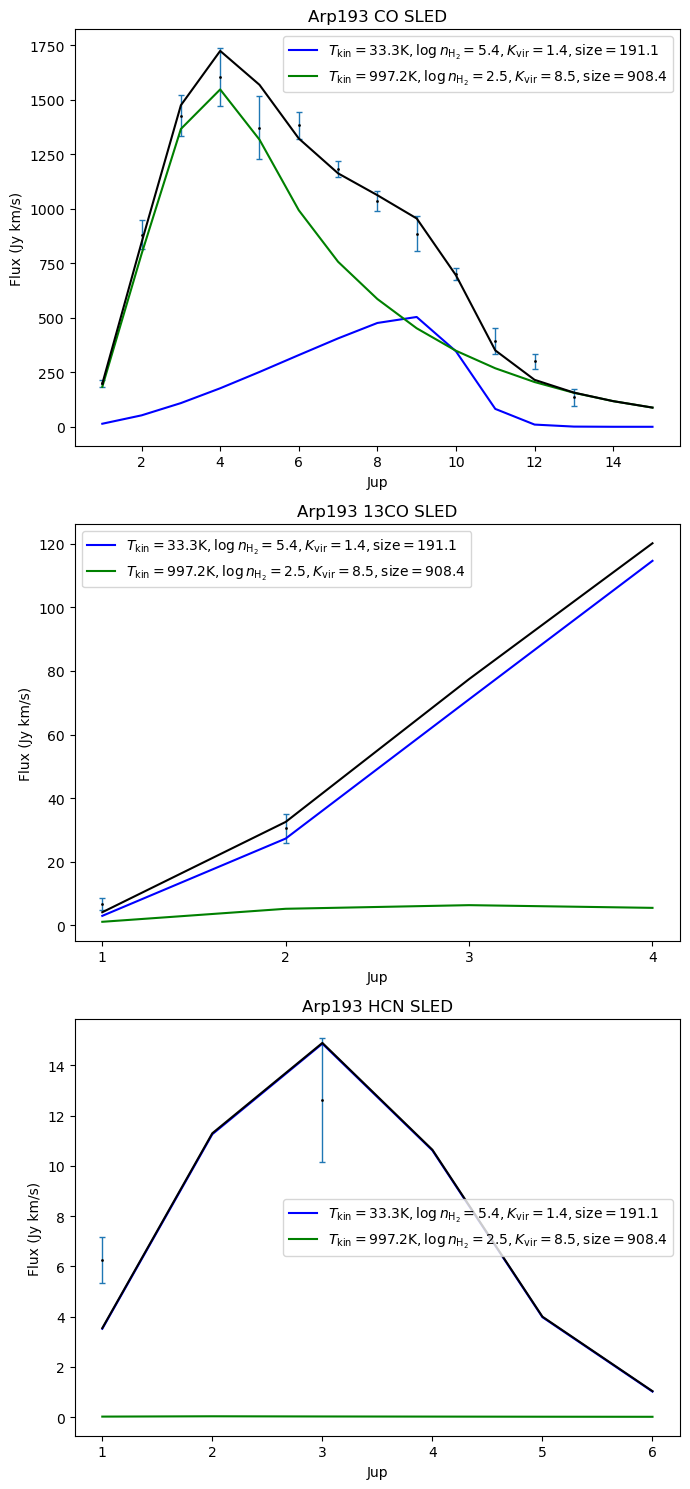

In [7]:
a193=galaxy('Arp193')
a193.load_flux('obs_data/Arp193.csv')
a193.mol_flux['CO'][1:4,2]/=2
a193.beam_match(40)
a193.dust_flux=np.array([[70,21.7,2.2],[100,25.6,2.5],[160,17.8,1.8],[250,6,0.6],[350,2.1,0.2],[500,0.5,0.05]])
a193.ncomp=2
a193.read_prior(priorfile='prior.txt')
a193.commandlist.insert(-3,"    ll+=limit_f(lummodel.mol_Tbs['CO'][0,1],20,40)")
a193.fit_SLED(ncomp=2,fit_dust=False)
a193.draw_corner(discard=8000)
a193.draw_SLED()